In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score,classification_report,precision_recall_curve, average_precision_score
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
import scikitplot as skplt
import string
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier


In [ ]:
df = pd.read_csv('product.csv')

## Text data visualization

   Unnamed: 0            brand  \
0           0  Universal Music   
1           1         Lundberg   
2           2         Lundberg   
3           3              K-Y   
4           4              K-Y   

                                          categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...   

                         manufacturer  reviews.rating  \
0  Universal Music Group / Cash Money               5   
1                            Lundberg               5   
2                            Lundberg               5   
3                                 K-Y               1   
4                                 K-Y               1   

                                        reviews.text     label  \
0  i love this album. it's very good. more to the

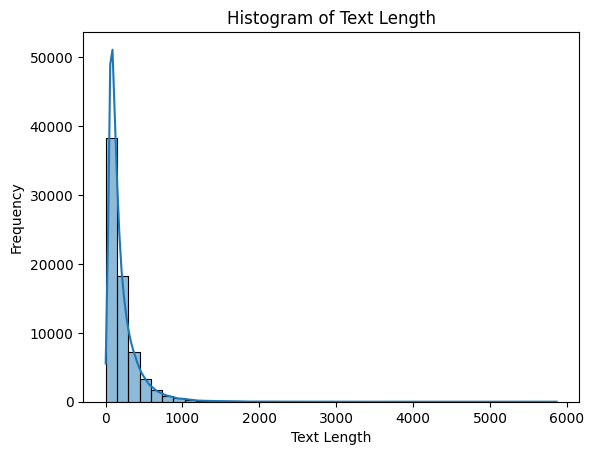

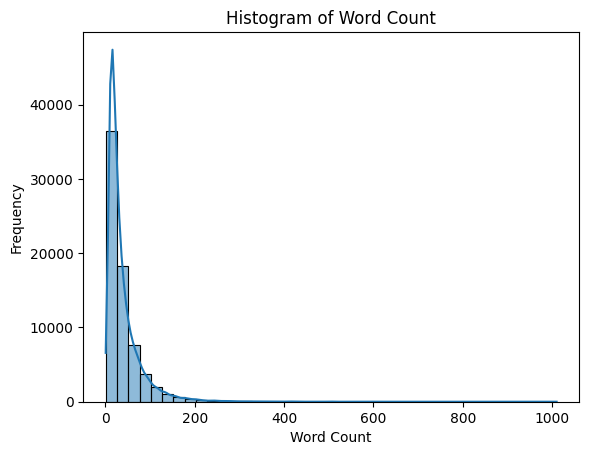

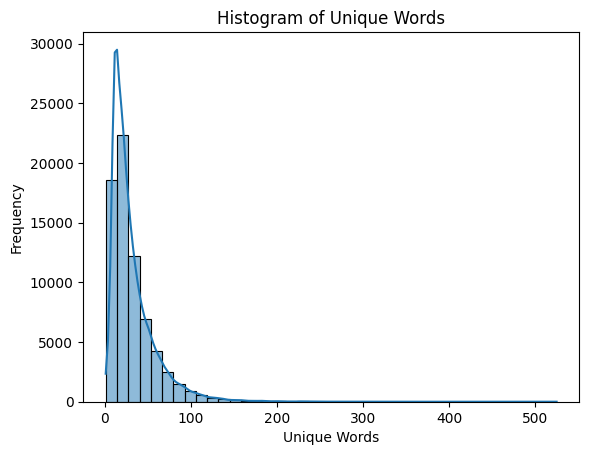

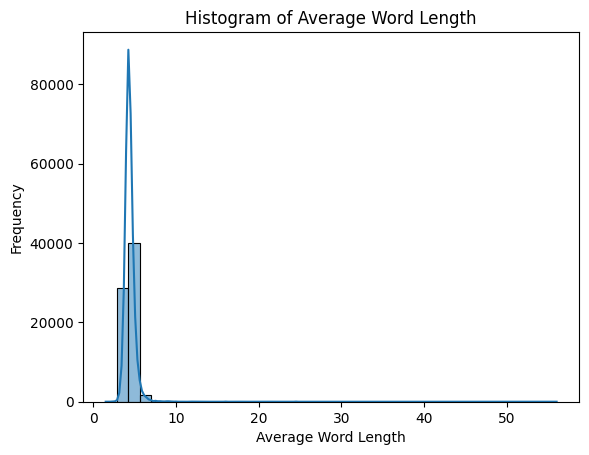

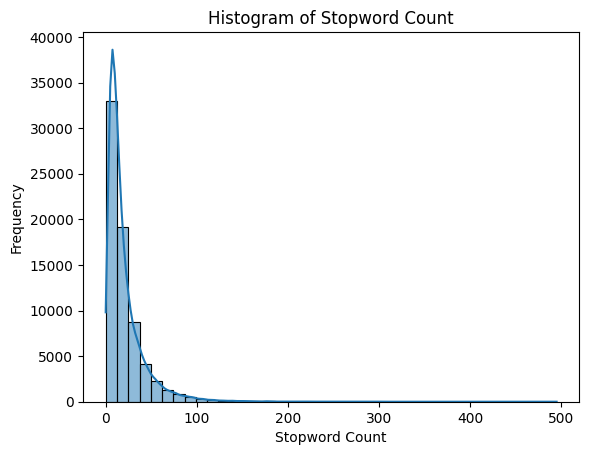

In [ ]:

# Text Length
df['Text Length'] = df['reviews.text'].apply(len)

# Word Count
df['Word Count'] = df['reviews.text'].apply(lambda x: len(str(x).split()))

# Unique Words
df['Unique Words'] = df['reviews.text'].apply(lambda x: len(set(str(x).split())))

# Average Word Length
df['Average Word Length'] = df['reviews.text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

# Stopword Count
stop_words = set(ENGLISH_STOP_WORDS)  # Set of common English stopwords
df['Stopword Count'] = df['reviews.text'].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop_words]))

# Display the DataFrame with all the calculated features
print(df.head())

# Plot histogram for Text Length
sns.histplot(df['Text Length'],bins=40,kde= True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length')
#plt.savefig('Histogram of Text Length',dpi =200)
plt.show()

# Plot histogram for Word Count
sns.histplot(df['Word Count'], bins=40, kde = True)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
#plt.savefig('Histogram of Word Count',dpi =200)
plt.show()

# Plot histogram for Unique Words
sns.histplot(df['Unique Words'], bins=40,kde = True)
plt.xlabel('Unique Words')
plt.ylabel('Frequency')
plt.title('Histogram of Unique Words')
#plt.savefig('Histogram of Unique Words',dpi =200)
plt.show()

# Plot histogram for Average Word Length
sns.histplot(df['Average Word Length'], bins=40,kde = True)
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.title('Histogram of Average Word Length')
#plt.savefig('Histogram of Average Word Length',dpi =200)
plt.show()

# Plot histogram for Stopword Count
sns.histplot(df['Stopword Count'], bins=40,kde = True)
plt.xlabel('Stopword Count')
plt.ylabel('Frequency')
plt.title('Histogram of Stopword Count')
#plt.savefig('Histogram of Stopword Count',dpi =200)
plt.show()


In [ ]:

dataset = df[['brand','manufacturer','reviews.rating', 'reviews.text']]
dataset.head()

,brand,manufacturer,reviews.rating,reviews.text
0,Universal Music,Universal Music Group / Cash Money,5,i love this album. it's very good. more to the...
1,Lundberg,Lundberg,5,Good flavor. This review was collected as part...
2,Lundberg,Lundberg,5,Good flavor.
3,K-Y,K-Y,1,I read through the reviews on here before look...
4,K-Y,K-Y,1,My husband bought this gel for us. The gel cau...


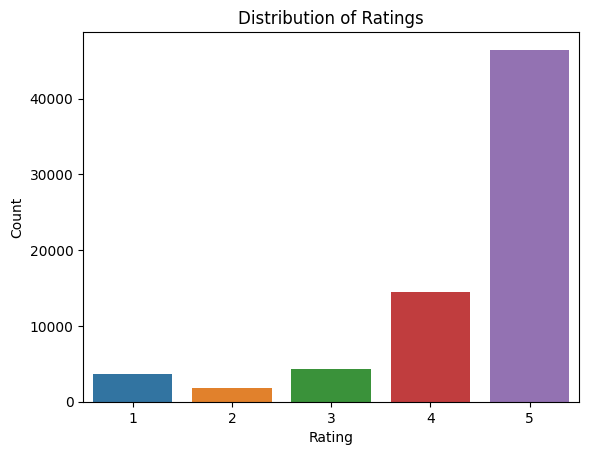

In [ ]:
data= dataset['reviews.rating'].value_counts()
sns.barplot(x = data.index, y = data.values)
#Add labels to the plot
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
#plt.savefig('Distribution of Ratings',dpi=200)

## Wordcloud

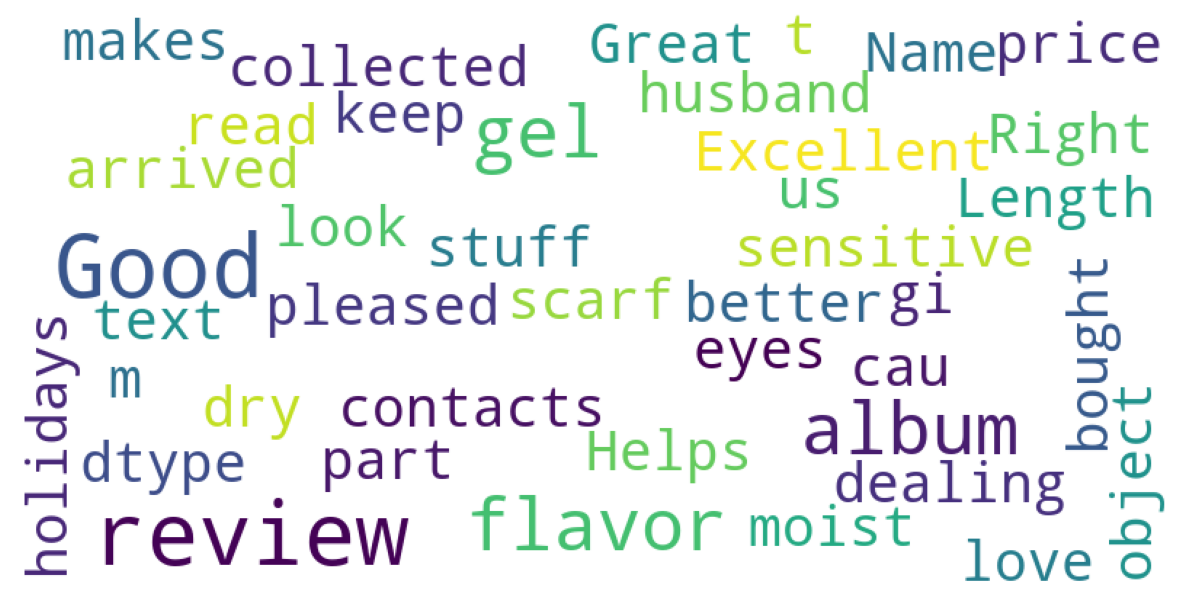

In [ ]:
stopwords = set(STOPWORDS)
def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=9
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    #plt.savefig('Wordcloud',dpi = 200)
    plt.show()

wordcloud(dataset['reviews.text'])


## Feature Transformation

In [ ]:
data=dataset['reviews.text']
train_data=dataset['reviews.text']
y_target=dataset['reviews.rating'].map({1:'Unhappy',2:'Unhappy',3:'Ok',4:'Happy',5:'Happy'})

In [ ]:
vectorize_word = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=10000)
vectorize_word.fit(data)
train_features_word = vectorize_word.transform(train_data)

In [ ]:
#Initialize the TfidfVectorizer with max_features and other parameters
vectorize_char = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', ngram_range=(2, 6), max_features=70000)

#Fit the vectorizer to your data
vectorize_char.fit(train_data)

#Define batch size (adjust as needed)
batch_size = 4000

#Initialize an empty list to store the transformed batches
train_features_char_list = []

#Process the data in batches
for i in tqdm(range(0, len(train_data), batch_size),desc = "Batch Processing"):
    batch_data = train_data.iloc[i : i + batch_size]  # Get the current batch
    batch_features_char = batch_data.apply(lambda x: vectorize_char.transform([x]))  # Transform the batch
    train_features_char_list.append(sp.vstack(batch_features_char))  # Append the transformed batch to the list

# Step 7: Concatenate the transformed batches into a single sparse matrix
train_features_char = sp.vstack(train_features_char_list)

Batch Processing: 100%|██████████| 18/18 [01:40<00:00,  5.57s/it]


In [ ]:
#Split the data into training and testing sets
X, X_test, y, y_test = train_test_split(train_features_char, y_target, test_size=0.3, random_state=101, shuffle=True)


## Validation

In [ ]:
#Split the data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


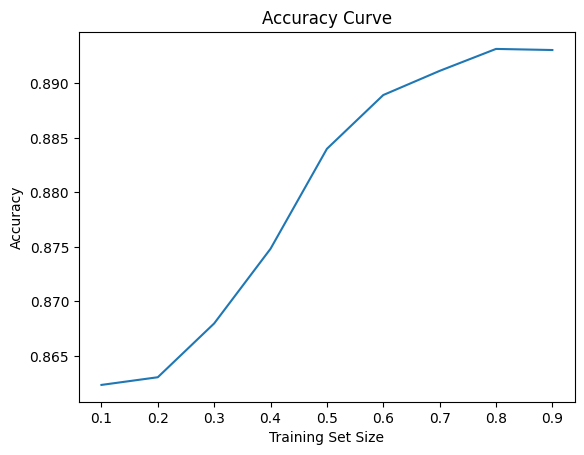

[0.8623261439225962, 0.8630316468453941, 0.8679701673049789, 0.8748236242693005, 0.8839951622656722, 0.888933682725257, 0.8911509776254787, 0.8931667002620439, 0.8930659141302156]


In [ ]:
# Step 2: Create a list of different training set sizes (e.g., 10%, 20%, ..., 90%)
train_sizes = np.arange(0.1, 1.0, 0.1)

# Step 3 and 4: Train the model and calculate accuracy for each training set size
accuracies = []
for train_size in train_sizes:
    # Calculate the number of samples based on the training set size
    num_samples = int(train_size * X_train.shape[0])
    
    # Select a subset of the training data
    X_train_subset = X_train[:num_samples]
    y_train_subset = y_train[:num_samples]
    
    # Initialize and train the Naive Bayes classifier
    classifier = MultinomialNB()
    classifier.fit(X_train_subset, y_train_subset)
    
    # Make predictions on the validation set
    y_pred = classifier.predict(X_val)
    
    # Calculate accuracy and store it in the list
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

# Step 5: Plot the accuracy curve
plt.plot(train_sizes, accuracies)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.savefig('Accuracy Curve',dpi =200)
plt.show()
print(accuracies)

In [ ]:
# Initialize and train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predict sentiment labels for the test set
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8882460843798504
Classification Report:
              precision    recall  f1-score   support

       Happy       0.91      0.98      0.94     18243
          Ok       0.42      0.04      0.07      1336
     Unhappy       0.65      0.61      0.63      1682

    accuracy                           0.89     21261
   macro avg       0.66      0.54      0.55     21261
weighted avg       0.86      0.89      0.86     21261



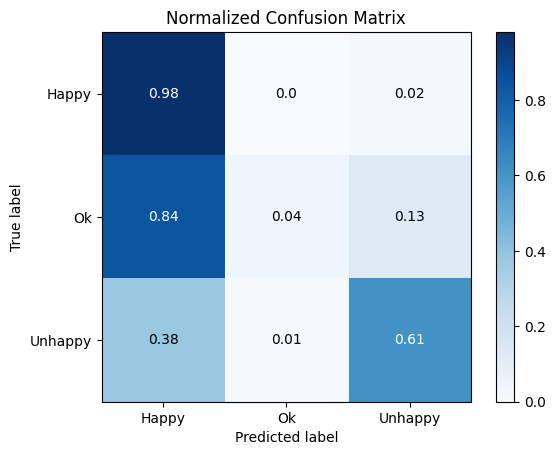

In [ ]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred,normalize= True)
#plt.savefig('Confusion_matrix',dpi =200)
plt.show()

## For PR Curve

Average Precision Score: 0.6192035946894033


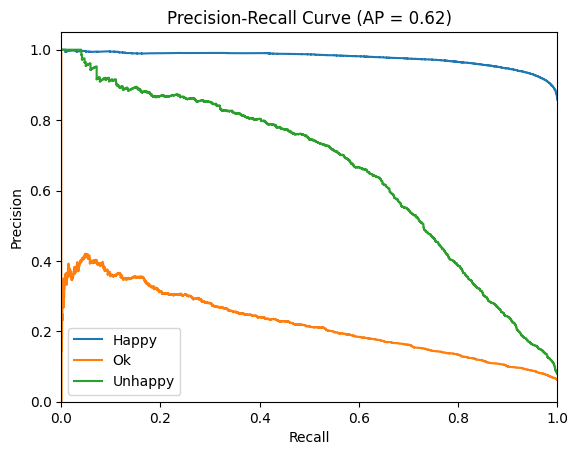

In [ ]:

#Binarize the target labels for the OneVsRestClassifier
y_bin = label_binarize(y_target, classes=np.unique(y_target))

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_features_char, y_bin, test_size=0.3, random_state=101)

#Create a OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(nb_classifier)

#Train the OneVsRestClassifier on the training data
ovr_classifier.fit(X_train, y_train)

#Get predicted probabilities (y_prob) for the test data
y_prob = ovr_classifier.predict_proba(X_test)

#Calculate and print average precision score
average_precision = average_precision_score(y_test, y_prob, average='macro')  # Use 'macro' average for multiclass problems
print("Average Precision Score:", average_precision)

#Calculate precision-recall pairs for various thresholds
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_prob.ravel())

#Plot the Precision-Recall Curve
plt.figure()
for i in range(y_prob.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    plt.step(recall, precision, where='post', label=class_labels[i].format(i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP = {0:0.2f})'.format(average_precision))
plt.legend(loc='best')
#plt.savefig('PR Curve',dpi =200)
plt.show()


## For ROC curve

In [ ]:
# Now, we need to convert the target variable 'y_target' to binary format for OvR strategy
y_binary = label_binarize(y_target, classes=np.unique(y_target))

In [ ]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_features_char, y_binary, test_size=0.2, random_state=101, shuffle=True)

In [ ]:
# Initialize and train the Naive Bayes classifier
nb_classifier = MultinomialNB()

In [ ]:
#Train the Naive Bayes classifier for each class separately (OvR strategy)
n_classes = y_binary.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
class_labels = np.unique(y_target)

for i in range(n_classes):
    nb_classifier.fit(X_train, y_train[:, i])
    y_probs = nb_classifier.predict_proba(X_test)[:, 1]
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

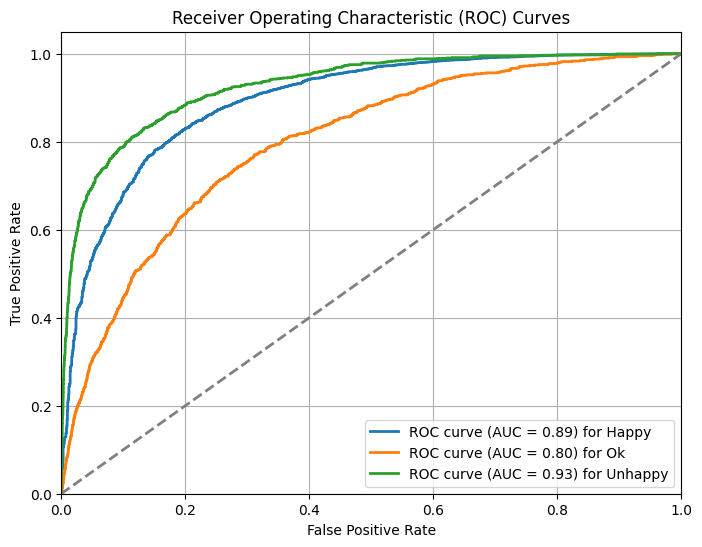

In [ ]:
#Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_labels[i]}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('ROC Curve',dpi =200)
plt.show()